## Practice

c:\Users\joshu\Desktop\uni\thesis_UCL\RCGP_experiments\tf-env\Lib\site-packages\gpflow\versions.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


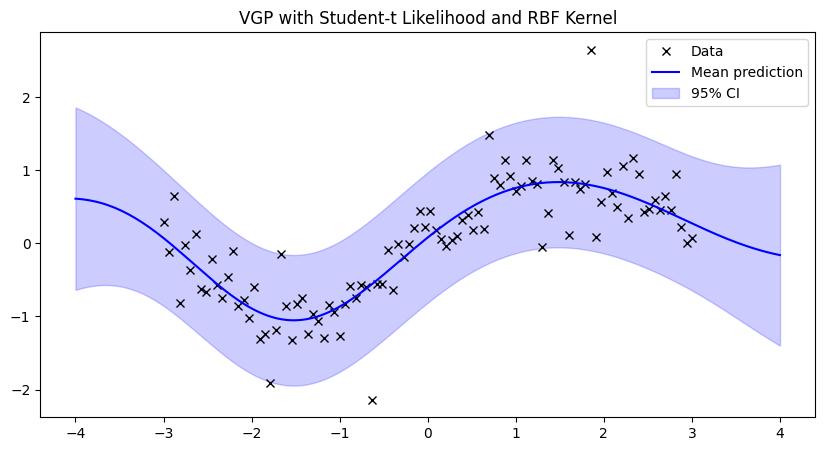

In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Generate synthetic dataset
X = np.linspace(-3, 3, 100).reshape(-1, 1)
Y = np.sin(X) + 0.3 * np.random.standard_t(df=3, size=X.shape)  # Heavy-tailed noise

X = X.astype(np.float64)
Y = Y.astype(np.float64)

# Step 2: Define the RBF kernel
kernel = gpflow.kernels.SquaredExponential()

# Step 3: Define the Student-t likelihood
likelihood = gpflow.likelihoods.StudentT(df=3.0)

# Step 4: Create the VGP model
model = gpflow.models.VGP(
    data=(X, Y),
    kernel=kernel,
    likelihood=likelihood
)

# Step 5: Train the model using a Scipy optimizer
opt = gpflow.optimizers.Scipy()

def objective_closure():
    return -model.maximum_log_likelihood_objective()

opt.minimize(objective_closure, model.trainable_variables, options=dict(maxiter=1000))

# Step 6: Make predictions
Xtest = np.linspace(-4, 4, 200).reshape(-1, 1)
mean, var = model.predict_y(Xtest)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(X, Y, 'kx', label='Data')
plt.plot(Xtest, mean, 'b', label='Mean prediction')
plt.fill_between(Xtest[:, 0],
                 mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
                 mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
                 color='blue', alpha=0.2, label='95% CI')
plt.title("VGP with Student-t Likelihood and RBF Kernel")
plt.legend()
plt.show()


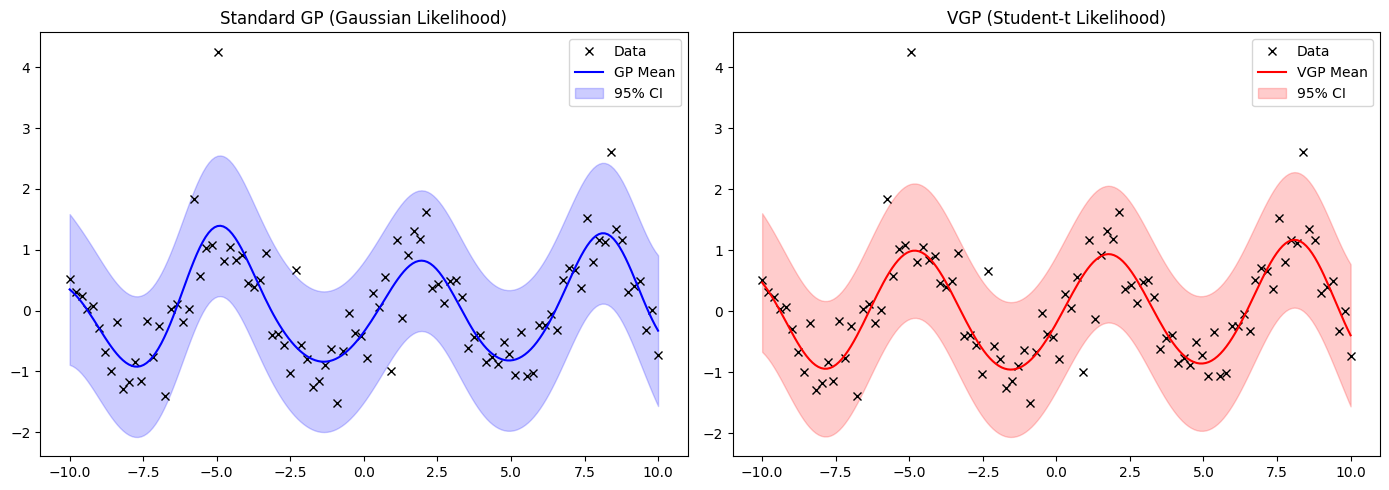

In [2]:
import gpflow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Step 1: Generate synthetic dataset with heavy-tailed noise
X = np.linspace(-10, 10, 100).reshape(-1, 1)
Y = np.sin(X) + 0.3 * np.random.standard_t(df=3, size=X.shape)  # Heavy-tailed noise

X = X.astype(np.float64)
Y = Y.astype(np.float64)

# Step 2: Define test points
Xtest = np.linspace(-10, 10, 200).reshape(-1, 1)

# ================================
# GP Model (standard regression)
# ================================
kernel_gp = gpflow.kernels.SquaredExponential()
model_gp = gpflow.models.GPR(
    data=(X, Y),
    kernel=kernel_gp,
    mean_function=None
)

# Optimize
opt = gpflow.optimizers.Scipy()
opt.minimize(
    model_gp.training_loss,
    model_gp.trainable_variables,
    options=dict(maxiter=1000)
)

# Predictions
mean_gp, var_gp = model_gp.predict_y(Xtest)

# ================================
# VGP Model with Student-t likelihood
# ================================
kernel_vgp = gpflow.kernels.SquaredExponential()
likelihood_vgp = gpflow.likelihoods.StudentT()
model_vgp = gpflow.models.VGP(
    data=(X, Y),
    kernel=kernel_vgp,
    likelihood=likelihood_vgp
)

# Optimize
def objective_closure_vgp():
    return -model_vgp.maximum_log_likelihood_objective()

opt.minimize(objective_closure_vgp, model_vgp.trainable_variables, options=dict(maxiter=1000))

# Predictions
mean_vgp, var_vgp = model_vgp.predict_y(Xtest)

# ================================
# Plot the results
# ================================
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# GP with Gaussian Likelihood
axs[0].plot(X, Y, 'kx', label='Data')
axs[0].plot(Xtest, mean_gp, 'b', label='GP Mean')
axs[0].fill_between(
    Xtest[:, 0],
    mean_gp[:, 0] - 1.96 * np.sqrt(var_gp[:, 0]),
    mean_gp[:, 0] + 1.96 * np.sqrt(var_gp[:, 0]),
    color='blue', alpha=0.2, label='95% CI'
)
axs[0].set_title("Standard GP (Gaussian Likelihood)")
axs[0].legend()

# VGP with Student-t Likelihood
axs[1].plot(X, Y, 'kx', label='Data')
axs[1].plot(Xtest, mean_vgp, 'r', label='VGP Mean')
axs[1].fill_between(
    Xtest[:, 0],
    mean_vgp[:, 0] - 1.96 * np.sqrt(var_vgp[:, 0]),
    mean_vgp[:, 0] + 1.96 * np.sqrt(var_vgp[:, 0]),
    color='red', alpha=0.2, label='95% CI'
)
axs[1].set_title("VGP (Student-t Likelihood)")
axs[1].legend()

plt.tight_layout()
plt.show()

## t-MOGP

In [40]:
import numpy as np

# Inputs for two tasks (here just using same inputs)
X_base = np.linspace(0, 10, 50).reshape(-1, 1)

# Repeat inputs for each task
X = np.vstack([X_base, X_base])  # shape (100, 1)

X_test_base = np.linspace(0, 10, 200).reshape(-1, 1)
X_test = np.vstack([X_test_base, X_test_base])

# Add task indices
task_indices = np.array([0]*50 + [1]*50).reshape(-1, 1)

# Final X shape: (100, 2)
X_multi = np.hstack([X, task_indices])

In [41]:
# Task 0: sin(x), Task 1: cos(x) + noise
Y_task_0 = np.sin(X_base) + 0.1 * np.random.randn(50, 1)
Y_task_1 = np.cos(X_base) + 0.1 * np.random.randn(50, 1)

# Stack outputs
Y_multi = np.vstack([Y_task_0, Y_task_1])  # shape (100, 1)

In [42]:
# Base kernel on input (X[:, 0])
k1 = gpflow.kernels.SquaredExponential(active_dims=[0])
k1.variance.assign(1.0)
gpflow.utilities.set_trainable(k1.variance, False)

# Coregion kernel on task index (X[:, 1])
k2 = gpflow.kernels.Coregion(output_dim=2, rank=1, active_dims=[1])
k2.kappa.assign([1e-6, 1e-6])
gpflow.utilities.set_trainable(k2.kappa, False)

# Multiply kernels
kernel = k1 * k2

In [43]:
from gpflow.models import GPR
import tensorflow as tf

likelihood_vgp = gpflow.likelihoods.StudentT()

model = gpflow.models.VGP(
    data=(X, Y),
    kernel=kernel,
    likelihood=likelihood_vgp
)
# model.likelihood.variance.assign(1e-4)  # Optional: fix noise

# Optimize
def objective_closure_vgp():
    return -model_vgp.maximum_log_likelihood_objective()

opt.minimize(objective_closure_vgp, model_vgp.trainable_variables, options=dict(maxiter=1000))


  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 85.67675666282926
        x: [ 5.100e-01 -1.125e+00 ...  2.814e-01 -9.875e-01]
      nit: 1
      jac: [ 6.983e-05  1.973e-06 ... -5.724e-04 -5.318e-05]
     nfev: 3
     njev: 3
 hess_inv: <5153x5153 LbfgsInvHessProduct with dtype=float64>

In [52]:
import matplotlib.pyplot as plt

# Number of tasks
num_tasks = 2

# Test inputs
X_test = np.linspace(0, 10, 200).reshape(-1, 1)

plt.figure(figsize=(10, 5))

for task in range(num_tasks):
    idx = X_multi[:, 1] == task
    X_train_task = X_multi[idx][:, 0]
    Y_train_task = Y_multi[idx][:, 0]

    mean, var = model.predict_y(X_test.flatten())
    lower = mean - 1.96 * np.sqrt(var)
    upper = mean + 1.96 * np.sqrt(var)

    # Plot
    plt.subplot(1, num_tasks, task + 1)
    plt.title(f"Task {task}")
    plt.plot(X_test, mean, 'C0', label='Predictive mean')
    plt.fill_between(X_test[:, 0], lower[:, 0], upper[:, 0], color='C0', alpha=0.3, label='95% CI')
    plt.plot(X_train_task, Y_train_task, 'kx', label='Training data')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()

plt.tight_layout()
plt.show()

ShapeMismatchError: 
Tensor shape mismatch.
  Function: GPModel.predict_y
    Declared: c:\Users\joshu\Desktop\uni\thesis_UCL\RCGP_experiments\tf-env\Lib\site-packages\gpflow\models\model.py:282
    Argument: Xnew
      Expected: [batch..., N, D]
      Actual:   [200]


<Figure size 1000x500 with 0 Axes>

In [ ]:
print("X_test shape:", X_test.shape)
print("task_col shape:", task_col.shape)
print("X_test_task shape:", X_test_task.shape)
print("Model input dimension expected:", model.input_shape)

X_test shape: (200, 1)
task_col shape: (200, 1)
X_test_task shape: (200, 2)


AttributeError: 'VGP' object has no attribute 'input_shape'

In [23]:
print("Kernel parameters:")
for param in model.kernel.trainable_parameters:
    print(f"{param.name}: {param.numpy()}")

print("\nLikelihood parameters:")
for param in model.likelihood.trainable_parameters:
    print(f"{param.name}: {param.numpy()}")


Kernel parameters:
softplus: 0.9999999999999999
identity: [[0.1]
 [0.1]]

Likelihood parameters:
chain_of_shift_of_softplus: 1.0


# Standard GP

In [29]:
import numpy as np

# Inputs for two tasks (here just using same inputs)
X_base = np.linspace(0, 10, 50).reshape(-1, 1)

# Repeat inputs for each task
X = np.vstack([X_base, X_base])  # shape (100, 1)

# Add task indices
task_indices = np.array([0]*50 + [1]*50).reshape(-1, 1)

# Final X shape: (100, 2)
X_multi = np.hstack([X, task_indices])


In [30]:
# Task 0: sin(x), Task 1: cos(x) + noise
Y_task_0 = np.sin(X_base) + 0.1 * np.random.randn(50, 1)
Y_task_1 = np.cos(X_base) + 0.1 * np.random.randn(50, 1)

# Stack outputs
Y_multi = np.vstack([Y_task_0, Y_task_1])  # shape (100, 1)

In [31]:
import gpflow
from gpflow.kernels import SquaredExponential, Coregion

# Base kernel on input (X[:, 0])
k1 = SquaredExponential(active_dims=[0])

# Coregion kernel on task index (X[:, 1])
k2 = Coregion(output_dim=2, rank=1, active_dims=[1])

# Multiply kernels
kernel = k1 * k2

In [32]:
from gpflow.models import GPR
import tensorflow as tf

model = GPR(data=(X_multi, Y_multi), kernel=kernel, mean_function=None)
model.likelihood.variance.assign(1e-4)  # Optional: fix noise

opt = gpflow.optimizers.Scipy()
opt.minimize(model.training_loss, model.trainable_variables)

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: -50.55915517376556
        x: [ 1.908e+00  8.207e-01  1.152e-01 -2.493e-01  8.348e-01
             5.126e-01 -4.692e+00]
      nit: 28
      jac: [-5.857e-06  4.187e-07 -5.148e-07  1.132e-07  2.548e-07
             2.050e-07  3.163e-06]
     nfev: 30
     njev: 30
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>

In [33]:
X_test = np.linspace(0, 10, 100).reshape(-1, 1)
task_0 = np.zeros((100, 1), dtype=int)
X_test_task_0 = np.hstack([X_test, task_0])

mean, var = model.predict_f(X_test_task_0)

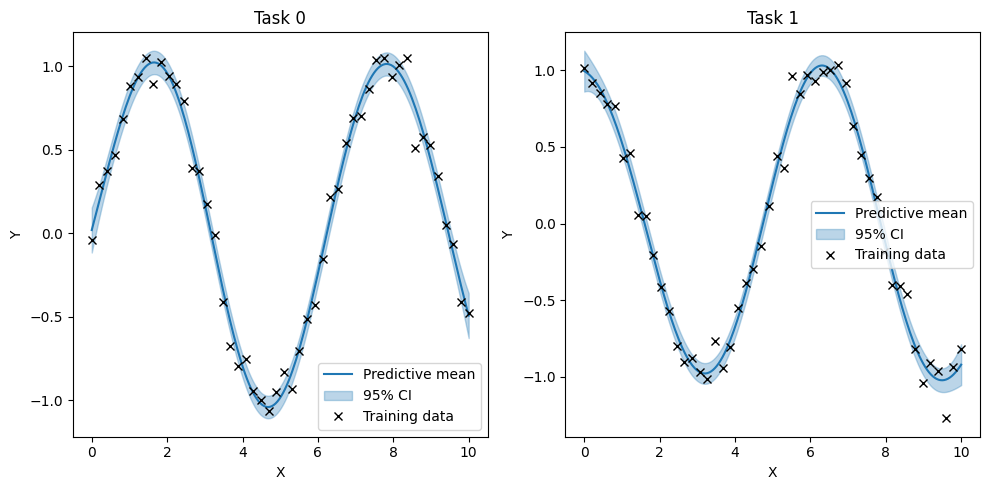

In [34]:
import matplotlib.pyplot as plt

# Number of tasks
num_tasks = 2

# Test inputs
X_test = np.linspace(0, 10, 200).reshape(-1, 1)

plt.figure(figsize=(10, 5))

for task in range(num_tasks):
    # Select training data for this task
    idx = X_multi[:, 1] == task
    X_train_task = X_multi[idx][:, 0]
    Y_train_task = Y_multi[idx][:, 0]

    # Create test input for this task (attach task index)
    task_col = np.full_like(X_test, task)
    X_test_task = np.hstack([X_test, task_col])

    # Predict
    mean, var = model.predict_f(X_test_task)
    lower = mean - 1.96 * np.sqrt(var)
    upper = mean + 1.96 * np.sqrt(var)

    # Plot
    plt.subplot(1, num_tasks, task + 1)
    plt.title(f"Task {task}")
    plt.plot(X_test, mean, 'C0', label='Predictive mean')
    plt.fill_between(X_test[:, 0], lower[:, 0], upper[:, 0], color='C0', alpha=0.3, label='95% CI')
    plt.plot(X_train_task, Y_train_task, 'kx', label='Training data')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()

plt.tight_layout()
plt.show()


# Test